In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [38]:
#Rosenbrock function with a=1,b=100
def f(x,y):
    return (1 - x)**2 + 100*(y - x**2)**2 

In [39]:
def Grad_f(x,y):
    g1 = -400*x*y + 400*x**3 + 2*x -2
    g2 = 200*y -200*x**2
    return np.array([g1,g2])

In [40]:
#Rosenbrock function constrained to a disk 
xmin, xmax, xstep = -1.5, 1.5, .2
ymin, ymax, ystep = -1.5, 1.5, .2

In [41]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [42]:
z = f(x, y)

In [43]:
#global minima is at (a,a^2)
minima = np.array([1., 1.])

In [44]:
f(*minima)

0.0

In [45]:
minima_ = minima.reshape(-1, 1)
minima_

array([[1.],
       [1.]])

In [46]:
f(*minima_)

array([0.])

In [47]:
#2D Contour Plot and Gradient Vector Field
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(f, argnum=1)(x, y)

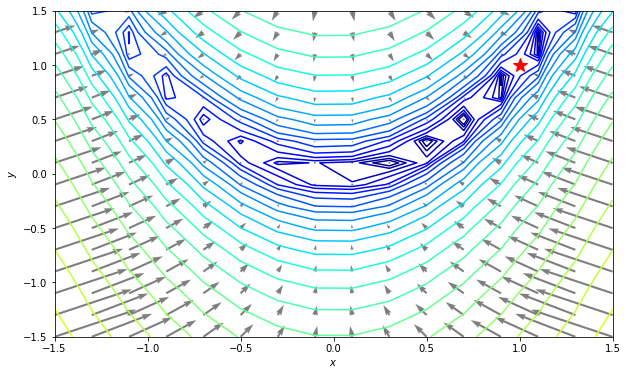

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
ax.plot(*minima_, 'r*', markersize=15)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [63]:
def Gradient_Descent(Grad,x,y, gamma = 0.00125, epsilon=0.0001, nMax = 10000 ):
    #Initialization
    i = 0
    iter_x, iter_y, iter_count = np.empty(0),np.empty(0), np.empty(0)
    error = 10
    X = np.array([x,y])
    
    #Looping as long as error is greater than epsilon
    while np.linalg.norm(error) > epsilon and i < nMax:
        i +=1
        iter_x = np.append(iter_x,x)
        iter_y = np.append(iter_y,y)
        iter_count = np.append(iter_count ,i)   
        #print(X) 
        
        X_prev = X
        X = X - gamma * Grad(x,y)
        error = X - X_prev
        x,y = X[0], X[1]
          
    print(X)
    return X, iter_x,iter_y, iter_count




In [64]:
root,iter_x,iter_y, iter_count = Gradient_Descent(Grad_f,-1,-1)

[0.91653862 0.83969197]


In [65]:
#Gradient-based Optimization
#Newton-CG
x0 = np.array([-1., -1.])

func = value_and_grad(lambda args: f(*args))

res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=print)

dict(res)

In [57]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

In [67]:
path_ = [x0]
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))
dict(res)

ValueError: Unknown solver Gradient_Descent

In [19]:
path = np.array(path_).T
path.shape

(2, 141)

(-1.5, 1.5)

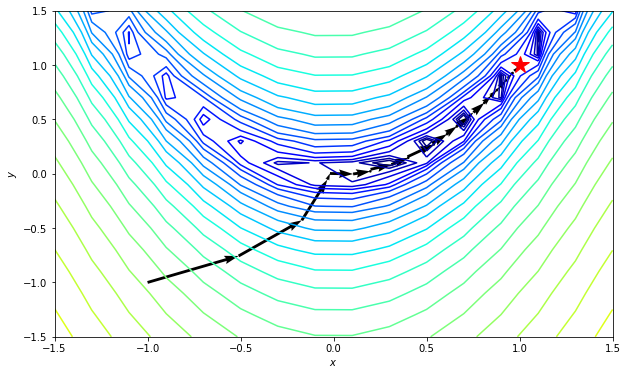

In [20]:
#Static Quiver Plot of Path on 2D Contour Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

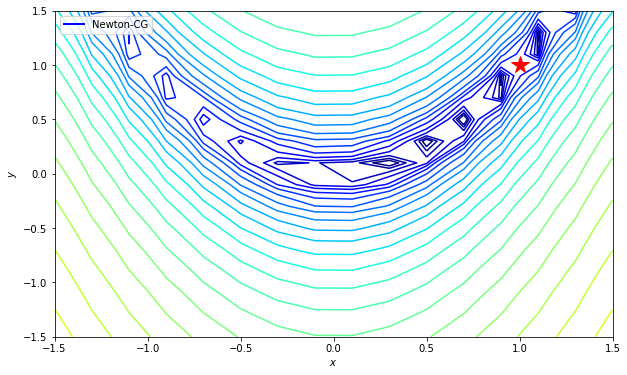

In [21]:
#Animating Single Path on 2D Contour Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Newton-CG', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

In [22]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

In [23]:
def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

In [24]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [25]:
HTML(anim.to_html5_video())

In [26]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [27]:
methods = [
    "CG",
    "Newton-CG",
    "BFGS",
]

In [28]:
minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

In [29]:
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)

In [30]:
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

C:\Users\Haixiang\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:516: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
C:\Users\Haixiang\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:516: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)
C:\Users\Haixiang\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:516: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


In [31]:
paths = [np.array(paths_[method]).T for method in methods]

In [32]:
zpaths = [f(*path) for path in paths]

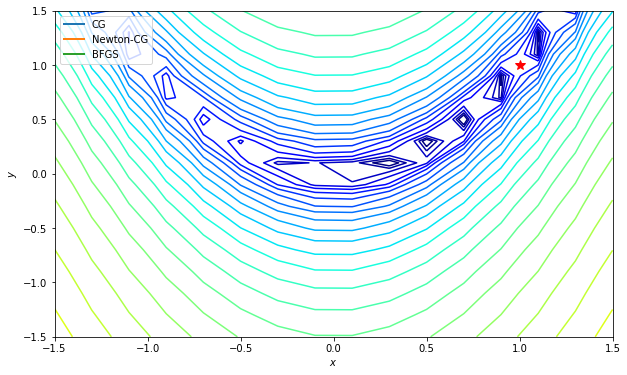

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [34]:
HTML(anim.to_html5_video())